#  Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [2]:
!pip install smdebug
!pip3 install torch==1.3.1+cpu torchvision==0.4.2+cpu -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [20]:
import sagemaker
import boto3

## Dataset
 Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [5]:
# # Command to download and unzip data
# !wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
# !unzip dogImages.zip

In [21]:
# Retrieve the sagemaker session
sagemaker_session=sagemaker.Session()

# Retrieve the sagemaker S3 bucket, region and role
bucket = sagemaker_session.default_bucket()
print("Default Bucket: {}".format(bucket))

region = sagemaker.Session().boto_region_name
print("AWS Region: {}".format(region))

role = sagemaker.get_execution_role()
print("RoleArn: {}".format(role))

# Set the prefix in the above bucket
prefix = "dog-image-data"
# Begin upload
#inputs = sagemaker_session.upload_data(path="./dogImages", bucket=bucket, key_prefix=prefix)

Default Bucket: sagemaker-us-east-1-115534842302
AWS Region: us-east-1
RoleArn: arn:aws:iam::115534842302:role/service-role/AmazonSageMaker-ExecutionRole-20220110T090185


In [22]:
inputs = 's3://sagemaker-us-east-1-115534842302/dog-image-data/'

## TRAIN WITH PRETRAINED MODEL

In [ ]:
from sagemaker.pytorch import PyTorch
import os

estimator = PyTorch(
    entry_point="train_model.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.large",
)

estimator.fit({'train': inputs})

2022-01-13 14:24:45 Starting - Starting the training job...
2022-01-13 14:25:10 Starting - Launching requested ML instancesProfilerReport-1642083885: InProgress
......
2022-01-13 14:26:10 Starting - Preparing the instances for training.........
2022-01-13 14:27:37 Downloading - Downloading input data............
2022-01-13 14:29:38 Training - Downloading the training image..
2022-01-13 14:47:53 Uploading - Uploading generated training modelValid set: Average accuracy: 71.73652694610779%
INFO:root:Learning Rate: 0.001
INFO:root:Momentum: 0.5
INFO:root:Batch Size: 32
INFO:root:Test Batch Size: 32
INFO:root:Epochs: 2
INFO:root:Running on Device cpu
Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
#015  0%|          | 0.00/44.7M [00:00<?, ?B/s]#015 59%|█████▉    | 26.4M/44.7M [00:00<00:00, 277MB/s]#015100%|██████████| 44.7M/44.7M [00:00<00:00, 276MB/s]
INFO:__main__:Valid set: Average accuracy: 65.988023952

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [8]:
# Declare your HP ranges, metrics etc.
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

hyperparameter_ranges = {
    "lr": ContinuousParameter(0.1, 0.11),
    "batch-size": CategoricalParameter([16, 32, 64, 128]),
    "epochs": IntegerParameter(1, 2)
}

objective_metric_name = "average test accuracy"
objective_type = "Maximize"
metric_definitions = [{"Name": "average test accuracy", "Regex": "Test set: Average accuracy: ([0-9\\.]+)"}]

In [9]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.large"
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [15]:
#  Fit your HP Tuner
tuner.fit({"train": inputs}) #  Remember to include your data channels

..................................................................................................................................................................................................!


In [16]:
#  Get the best estimators and the best HPs
best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2022-01-13 15:07:17 Starting - Preparing the instances for training
2022-01-13 15:07:17 Downloading - Downloading input data
2022-01-13 15:07:17 Training - Training image download completed. Training in progress.
2022-01-13 15:07:17 Uploading - Uploading generated training model
2022-01-13 15:07:17 Completed - Training job completed


{'_tuning_objective_metric': '"average test accuracy"',
 'batch-size': '"32"',
 'epochs': '1',
 'lr': '0.1022061234548314',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2022-01-13-14-52-11-821"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-115534842302/pytorch-training-2022-01-13-14-52-11-821/source/sourcedir.tar.gz"'}

In [17]:
hyperparameters = {"batch-size": int(best_estimator.hyperparameters()['batch-size'].replace('"', '')), \
                   "lr": best_estimator.hyperparameters()['lr'],
                   "epochs": best_estimator.hyperparameters()['epochs']}
hyperparameters

{'batch-size': 32, 'lr': '0.1022061234548314', 'epochs': '1'}

## Model Profiling and Debugging
 Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [16]:
#  Set up debugging and profiling rules and hooks
from sagemaker.debugger import (
    Rule,
    DebuggerHookConfig,
    ProfilerRule,
    rule_configs,
    ProfilerConfig, 
    FrameworkProfile,
    
)

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

hook_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "10",
        "eval.save_interval": "10"
    }
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=1000, framework_profile_params=FrameworkProfile(num_steps=1)
)

In [18]:
hyperparameters = {'batch-size': 32, 'lr': '0.1022061234548314', 'epochs': '1'}

In [32]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point='train_model.py',
    base_job_name='dogImageEstimator',
    role=role,
    instance_count=1,
    instance_type='ml.m5.xlarge',
    framework_version='1.8',
    py_version='py3',
    hyperparameters=hyperparameters,
    rules = rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)

estimator.fit({"train": inputs}, wait = True)


2022-01-13 21:35:59 Starting - Starting the training job...
2022-01-13 21:36:25 Starting - Launching requested ML instancesVanishingGradient: InProgress
Overfit: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2022-01-13 21:37:25 Starting - Preparing the instances for training.........
2022-01-13 21:38:46 Downloading - Downloading input data.........
2022-01-13 21:40:26 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-01-13 21:40:24,790 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-01-13 21:40:24,793 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-01-13 21:40:24,801 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-01-13 21:40:26,243 sagemaker_pytorch_container.training INFO     Invoking user t

In [36]:
# TODO: Plot a debugging output.
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

trial.tensor_names()

[2022-01-13 21:56:40.860 mxnet-1-8-cpu-py37-ub-ml-t3-medium-5294afa9427a8e8e60e171a3c925:353 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-115534842302/dogImageEstimator-2022-01-13-21-35-58-543/debug-output
[2022-01-13 21:56:42.341 mxnet-1-8-cpu-py37-ub-ml-t3-medium-5294afa9427a8e8e60e171a3c925:353 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-01-13 21:56:43.361 mxnet-1-8-cpu-py37-ub-ml-t3-medium-5294afa9427a8e8e60e171a3c925:353 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight']

In [37]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN))

21

In [38]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [39]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL))

3

In [40]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


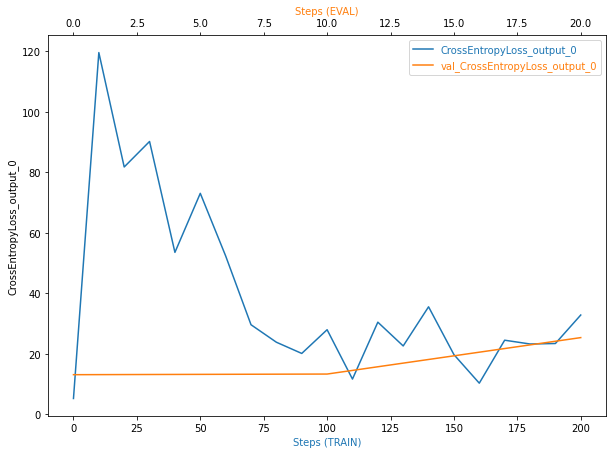

In [41]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [42]:
#  Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
rule_output_path

's3://sagemaker-us-east-1-115534842302/dogImageEstimator-2022-01-13-21-35-58-543/rule-output'

In [44]:
!aws s3 ls {rule_output_path} --recursive

2022-01-13 21:46:04     375089 dogImageEstimator-2022-01-13-21-35-58-543/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-01-13 21:46:03     223019 dogImageEstimator-2022-01-13-21-35-58-543/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-01-13 21:45:58        191 dogImageEstimator-2022-01-13-21-35-58-543/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-01-13 21:45:58        199 dogImageEstimator-2022-01-13-21-35-58-543/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-01-13 21:45:58       1924 dogImageEstimator-2022-01-13-21-35-58-543/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-01-13 21:45:58        127 dogImageEstimator-2022-01-13-21-35-58-543/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-01-13 21:45:58        198 dogImageEstimator-2022-01-13-21-35-58-543/rule-output/ProfilerReport/profiler-output/prof

In [46]:
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [33]:
predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.m5.large')
#predictor = estimator.deploy(initial_instance_count=1, instance_type="ml.t2.medium")

-------!

In [ ]:
#   Run a prediction on the endpoint

from PIL import Image
import torchvision.transforms as transforms

transform = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
PIL_image = Image.open("dogImages/test/001.Affenpinscher/Affenpinscher_00071.jpg") 
image = transform(PIL_image) #   Your code to load and preprocess image to send to endpoint for prediction
payload = image.unsqueeze(dim=0) #  Changes the shape of tensor from [224, 224, 3] to [1, 3, 224, 224].
response = predictor.predict(payload) # Make your prediction


In [59]:
import numpy as np
np.argmax(response, 1)

array([22])

In [45]:
#  Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()